(50000, 10)
[21900 21562 14066 21637 11235 20902 12626 11562 11503 13435]
[7.99866199e-04 3.62776213e-05 1.30201130e-05 1.55442109e-04
 1.01100373e-05 1.35887798e-05 1.17266111e-05 1.97994484e-05
 1.11835609e-05 1.40510394e-05]
(50000, 10)
[24582 10853 12628 19673 16419 13050 23229 12191 16849 12269]
[7.75393491e-04 1.47321713e-05 1.02489449e-05 2.31005337e-05
 1.35137986e-05 1.00098748e-05 1.61989210e-03 1.14390362e-05
 1.00158657e-05 1.01125414e-05]


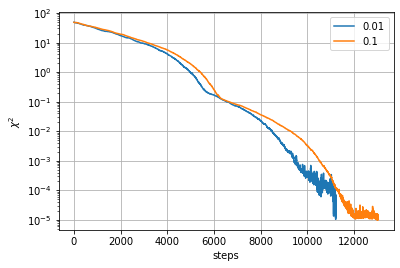

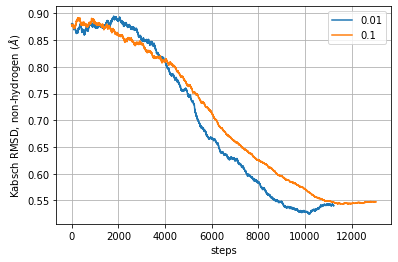

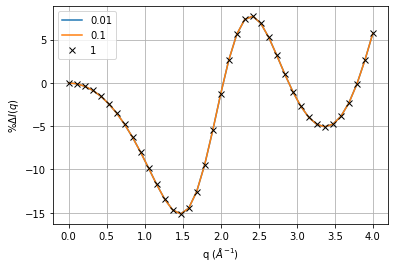

In [59]:
import numpy as np
import matplotlib.pyplot as p

title = 'nmm'
plot_bool = False
png_plot = False

stepsize_list=(0.01, 0.1, 1.0)
gamma_list=(4.0, 8.0)
qmax_list=(2.0, 4.0, 8.0, 16.0)
noise_list=(0.0, 0.1, 0.5)

stepsize_list=[0.01]
#gamma_list=[8.0]
qmax_list=[4.0]
noise_list=[0.0]

for ss in stepsize_list:
    for gg in gamma_list:
        for qq in qmax_list:
            for nn in noise_list:
                data_file = ('nmm_data/data_stepsize_%3.2f_gamma_%2.1f_qmax_%2.1f_noise_%3.2f.npz' 
                            % (ss, gg, qq, nn))
                f = np.load(data_file)
                target_pcd = f['target_pcd']
                chi2_path_array = f['chi2_path_array']
                rmsd_path_array = f['rmsd_path_array']
                final_pcd_array = f['final_pcd_array']
                final_xyz_array = f['final_xyz_array']
                counts_array = f['counts_array']
                step_size = f['step_size']
                cooling_rate = f['cooling_rate']
                #noise_factor = f['noise_factor']
                noise_factor = nn
                qvector = f['qvector']
                qmax = qvector[-1]
                nruns = len(counts_array)

                # find best runs
                print(chi2_path_array.shape)
                counts_array_int = np.array(counts_array, dtype='int')
                print(counts_array_int)
                chi2_end_values = np.zeros(nruns)
                for i in range(nruns):
                    chi2_end_values[i] = chi2_path_array[counts_array_int[i]-1, i]
                print(chi2_end_values)
                min_index = np.argmin(chi2_end_values)
                min_chi2_path = chi2_path_array[:counts_array_int[min_index] - 1, min_index]
                
                p.figure(0)
                p.semilogy(min_chi2_path)
                p.ylabel('$\chi^2$')
                p.xlabel('steps')
                p.legend((0.01, 0.1, 1))
                
                p.figure(1)
                p.plot(rmsd_path_array[:counts_array_int[min_index] - 1, min_index])
                p.ylabel(r'Kabsch RMSD, non-hydrogen $(\AA)$')
                p.xlabel('steps')
                p.legend((0.01, 0.1, 1))

                p.figure(2)
                #p.plot(qvector, target_pcd, 'bx')
                p.plot(qvector, final_pcd_array[:, min_index])
                p.xlabel(r'q $(\AA^{-1})$')
                p.ylabel('%$\Delta I(q)$')


                def nice_plot(
                    data, xlab, ylab, legend=(), 
                    log_scale=False, png_plot=False, fname=''
                ):
                    p.figure()
                    for i in range(data.shape[1]):
                        c = int(counts_array[i])
                        p.semilogy(data[:c, i]) if log_scale else p.plot(data[:c, i])
                    p.xlabel(xlab)
                    p.ylabel(ylab)
                    p.legend(legend)
                    p.grid()
                    if png_plot:
                        p.savefig(fname, dpi=300, facecolor='w', 
                            edgecolor='w', orientation='portrait', 
                            format='png', transparent=False, 
                            bbox_inches='tight', pad_inches=0.1, 
                            metadata=None)
                    return
                if plot_bool:
                    nice_plot(chi2_path_array, 'steps', '$\chi^2$', (), True, png_plot, 
                              '%s_chi2_stepsize_%3.2f_gamma_%2.1f_qmax_%2.1f_noise_%3.2f.png' % 
                              (title, step_size, cooling_rate, qmax, noise_factor))
                    nice_plot(rmsd_path_array, 'steps', r'Kabsch RMSD, non-hydrogen $(\AA)$', (), False, png_plot,
                                       '%s_rmsd_stepsize_%3.2f_gamma_%2.1f_qmax_%2.1f_noise_%3.2f.png' % 
                              (title, step_size, cooling_rate, qmax, noise_factor))
                    #nice_plot(final_pcd_array, 'q', r'%$\Delta I$', ())
                    #nice_plot(temp_path, 'steps', 'T', ())
                    p.figure()
                    p.plot(qvector, target_pcd, 'bo')
                    for i in range(nruns):
                        p.plot(qvector, final_pcd_array[:, i])
                    p.xlabel('q $(\AA^{-1})$')
                    p.ylabel('%$\Delta I(q)$')
                    p.legend(('target', 'fit'))
                    p.grid()
                if png_plot:
                    fname = ('%s_pcdfit_stepsize_%3.2f_gamma_%2.1f_qmax_%2.1f_noise_%3.2f.png' % 
                          (title, step_size, cooling_rate, qmax, noise_factor))
                    p.savefig(fname, dpi=300, facecolor='w', 
                            edgecolor='w', orientation='portrait', 
                            format='png', transparent=False, 
                            bbox_inches='tight', pad_inches=0.1, 
                            metadata=None)

                residual_plot = False
                if residual_plot:
                    p.figure()
                    for i in range(nruns):
                        p.plot(qvector, (final_pcd_array[:, i] - target_pcd)**2)
                    p.xlabel('q $(\AA^{-1})$')
                    p.ylabel('(fit - target)$^2$')
                    #p.ylim((0, 0.003))
                    p.legend(())
                    p.grid()
                #ypos = 1
                #xpos = 1
                #plt.text(xpos, ypos, '$<\chi^2> = %6.4f$' % chi2, 
                #             horizontalalignment='center',
                #             verticalalignment='center',
                #             bbox=dict(facecolor='white', alpha=1.0))
                
p.figure(0)
p.grid()

p.figure(1)
p.grid()

p.figure(2)
p.plot(qvector, target_pcd, 'kx')
p.legend((0.01, 0.1, 1, 'target'))
p.grid()